# BERT with FAST.AI
Amanda Maiwald, Martin Falli, Radoslav Evtimov

## Import libraries, data and setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, KFold
import random

from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.feature_extraction.text import TfidfVectorizer

from keras.preprocessing import text, sequence
from keras.layers import Embedding, SpatialDropout1D
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, Input
from keras.optimizers import RMSprop
import keras.backend as K
from keras.layers import Dense, Input, GRU, LSTM, Bidirectional, Dropout, CuDNNLSTM, CuDNNGRU
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold

Using TensorFlow backend.


In [0]:
# Directory structure
base_dir = '/content/drive/My Drive/BERT/BERT_Code_Input_Output/'
data_dir = base_dir + 'Data/'
model_dir = base_dir + 'NB/Model_Output_FASTAI'

In [0]:
train = pd.read_csv(data_dir + 'train_cleaned_no_punkt.csv') 

## Data preparation

In [0]:
train['mal'] = train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1) >= 1
train['nonmal'] = train['mal'] != 1
train['mal'] = train['mal'].astype(int)
train['nonmal'] = train['nonmal'].astype(int)
train.drop(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'], axis=1, inplace=True)
train.comment_text.fillna("empty", inplace=True)


In [6]:
train.head(3)

,id,comment_text,mal,nonmal
0,0000997932d777bf,explanation why edits made under my username h...,0,1
1,000103f0d9cfb60f,d aww he matches this background colour i seem...,0,1
2,000113f07ec002fd,hey man i really not trying to edit war just t...,0,1


In [0]:
train, test = train_test_split(train, test_size = 0.2, stratify = train.mal)

In [8]:
true_labels = test.iloc[:,2:4]
true_labels.head(3)

,mal,nonmal
96375,0,1
26516,0,1
101101,1,0


In [9]:
test.drop(['mal', 'nonmal'], axis=1, inplace=True) 
test.head(3)

,id,comment_text
96375,037b05a61cc78d13,to national express malaysia blogspot com chin...
26516,464294b24a918b7e,hey redvers mabe you can help me out i keep tr...
101101,1d2363be11c1db09,you raging gay and i think you so sad that you...


In [0]:
train, val = train_test_split(train, test_size = 0.2, stratify = train.mal)

In [0]:
import numpy as np
import pandas as pd

from pathlib import Path
from typing import *

import torch
import torch.optim as optim

In [0]:
from fastai import *
from fastai.vision import *
from fastai.text import *
from fastai.callbacks import *

In [0]:
%%bash
pip install pytorch-pretrained-bert

In [0]:
class Config(dict):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        for k, v in kwargs.items():
            setattr(self, k, v)
    
    def set(self, key, val):
        self[key] = val
        setattr(self, key, val)

config = Config(
    testing=False,
    bert_model_name="bert-base-uncased",
    max_lr=3e-5,
    epochs=3,
    use_fp16=True,
    bs=32,
    discriminative=False,
    max_seq_len=256,
)

In [0]:
from pytorch_pretrained_bert import BertTokenizer
bert_tok = BertTokenizer.from_pretrained(
    config.bert_model_name,
)

In [0]:
def _join_texts(texts:Collection[str], mark_fields:bool=False, sos_token:Optional[str]=BOS):
    """Borrowed from fast.ai source"""
    if not isinstance(texts, np.ndarray): texts = np.array(texts)
    if is1d(texts): texts = texts[:,None]
    df = pd.DataFrame({i:texts[:,i] for i in range(texts.shape[1])})
    text_col = f'{FLD} {1} ' + df[0].astype(str) if mark_fields else df[0].astype(str)
    if sos_token is not None: text_col = f"{sos_token} " + text_col
    for i in range(1,len(df.columns)):
        #text_col += (f' {FLD} {i+1} ' if mark_fields else ' ') + df[i]
        text_col += (f' {FLD} {i+1} ' if mark_fields else ' ') + df[i].astype(str)
    return text_col.values

In [0]:
class FastAiBertTokenizer(BaseTokenizer):
    """Wrapper around BertTokenizer to be compatible with fast.ai"""
    def __init__(self, tokenizer: BertTokenizer, max_seq_len: int=128, **kwargs):
        self._pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len

    def __call__(self, *args, **kwargs):
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length"""
        return ["[CLS]"] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + ["[SEP]"]

In [0]:
if config.testing:
    train = train.head(1024)
    val = val.head(1024)
    test = test.head(1024)

In [0]:
fastai_bert_vocab = Vocab(list(bert_tok.vocab.keys()))

In [0]:
fastai_tokenizer = Tokenizer(tok_func=FastAiBertTokenizer(bert_tok, max_seq_len=config.max_seq_len), pre_rules=[], post_rules=[])

In [0]:
label_cols = ["mal", "nonmal"]

Pass our own list of Preprocessors to the databunch.

In [0]:
class BertTokenizeProcessor(TokenizeProcessor):
    def __init__(self, tokenizer):
        super().__init__(tokenizer=tokenizer, include_bos=False, include_eos=False)

class BertNumericalizeProcessor(NumericalizeProcessor):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, vocab=Vocab(list(bert_tok.vocab.keys())), **kwargs)

def get_bert_processor(tokenizer:Tokenizer=None, vocab:Vocab=None):
    """
    Constructing preprocessors for BERT
    We remove sos/eos tokens since we add that ourselves in the tokenizer.
    We also use a custom vocabulary to match the numericalization with the original BERT model.
    """
    return [BertTokenizeProcessor(tokenizer=tokenizer),
            NumericalizeProcessor(vocab=vocab)]

In [0]:
class BertDataBunch(TextDataBunch):
    @classmethod
    def from_df(cls, path:PathOrStr, train_df:DataFrame, valid_df:DataFrame, test_df:Optional[DataFrame]=None,
                tokenizer:Tokenizer=None, vocab:Vocab=None, classes:Collection[str]=None, text_cols:IntsOrStrs=1,
                label_cols:IntsOrStrs=0, label_delim:str=None, **kwargs) -> DataBunch:
        "Create a `TextDataBunch` from DataFrames."
        p_kwargs, kwargs = split_kwargs_by_func(kwargs, get_bert_processor)
        # use our custom processors while taking tokenizer and vocab as kwargs
        processor = get_bert_processor(tokenizer=tokenizer, vocab=vocab, **p_kwargs)
        if classes is None and is_listy(label_cols) and len(label_cols) > 1: classes = label_cols
        src = ItemLists(path, TextList.from_df(train_df, path, cols=text_cols, processor=processor),
                        TextList.from_df(valid_df, path, cols=text_cols, processor=processor))
        src = src.label_for_lm() if cls==TextLMDataBunch else src.label_from_df(cols=label_cols, classes=classes)
        if test_df is not None: src.add_test(TextList.from_df(test_df, path, cols=text_cols))
        return src.databunch(**kwargs)

In [24]:
databunch = BertDataBunch.from_df(".", train, val, test,
                  tokenizer=fastai_tokenizer,
                  vocab=fastai_bert_vocab,
                  text_cols="comment_text",
                  label_cols=label_cols,
                  bs=config.bs,
                  collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),
             )

# Model

In [0]:
from pytorch_pretrained_bert.modeling import BertConfig, BertForSequenceClassification
bert_model = BertForSequenceClassification.from_pretrained(config.bert_model_name, num_labels=2) 

In [0]:
loss_func = nn.BCEWithLogitsLoss()

In [0]:
from fastai.callbacks import *

learner = Learner(
    databunch,
    bert_model,
    loss_func=loss_func,
    metrics = [accuracy]
)
if config.use_fp16: learner = learner.to_fp16()

In [28]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


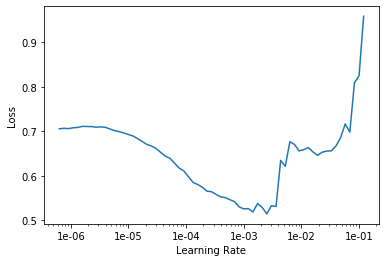

In [29]:
learner.recorder.plot() 

In [31]:
learner.fit_one_cycle(config.epochs, max_lr=config.max_lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.101726,0.091342,0.500000,14:05
1,0.075035,0.094275,0.500000,12:31
2,0.039758,0.099774,0.500000,12:34


In [0]:
learner.export(model_dir + '/' 'export.pkl')

In [33]:
#loaded_learner = load_learner(model_dir + '/')

In [0]:
def get_preds_as_nparray(ds_type) -> np.ndarray:
    """
    the get_preds method does not yield the elements in order by default
    we borrow the code from the RNNLearner to resort the elements into their correct order
    """
    preds = learner.get_preds(ds_type)[0].detach().cpu().numpy()
    sampler = [i for i in databunch.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    return preds[reverse_sampler, :]

In [35]:
test_preds = get_preds_as_nparray(DatasetType.Test)

In [36]:
probs = pd.DataFrame(test_preds)
probs.head(3)

,0,1
0,0.000538,0.999518
1,0.050237,0.950503
2,0.998408,0.001681


In [0]:
probs.to_csv(model_dir + "/" + "FASTAI_predictions.csv", index=False)
#probs = pd.read_csv(model_dir + "/" + 'FASTAI_probabilities.csv') 

In [0]:
threshold = 0.3

In [39]:
probs.head(1)

,0,1
0,0.000538,0.999518


In [0]:
probs_class = probs.copy()
probs_class['mal'] = np.where(probs_class.iloc[:,0] >= threshold, 1, 0)
columns = [0,1]
probs_class.drop(probs_class.columns[columns], axis=1,inplace=True)

In [0]:
y_pred = probs_class.mal

In [0]:
y_true = true_labels.mal

In [0]:
import sklearn
from sklearn import metrics

auc_pr = average_precision_score(y_true, probs.iloc[:,0])
auc_roc = roc_auc_score(y_true, probs.iloc[:,0])
f1 = sklearn.metrics.f1_score(y_true, y_pred)

In [45]:
print("AUC PR: ", round(auc_pr,4))
print("AUC ROC: ", round(auc_roc,4))
print("F1 score: ", round(f1,4))

AUC PR:  0.9271
AUC ROC:  0.9869
F1 score:  0.8437


In [0]:
# free up memory
#learner.destroy()